In [ ]:
'''
This notebook demonstrates splitting the data in half and using each half
to build a model which performs very well on the public LB with minimal feature engineering
'''

## Half model
This notebook demonstrates splitting the data in half and using each half to build a model which performs very well on the public LB with minimal feature engineering.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import math
import timeit
import gc
import os
import random

# Visualiazation
from seaborn import countplot
import matplotlib.pyplot as plt
import seaborn

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score, mean_squared_error

# Models and multiclasses support
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier

# Model tuning
from sklearn.model_selection import GridSearchCV

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding cla

In [2]:
# Settings
path_data = 'input_files/TEST/'
path_train = path_data + 'train.csv'
path_test = path_data + 'test.csv'

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

# Is it regression/binary classification/multi class classification?
task = 1  # regression
task = 2  # binary classification
task = 3  # multiclass classification

# Number of classes for multiclass
num_class = 4

In [3]:
task = 3  # multi class classification

In [4]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    ''' Roc auc calculation for multiclass task '''

    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

def seconds_to_str(time_taken: float) -> str:
    '''
    Returns hours, minutes, seconds from the time taken

    Parameters:
        :params time_taken: time taken

    Returns:
        :returns: hours, minutes, seconds from the time taken
    '''

    hours, rest = divmod(time_taken, 3600)
    minutes, seconds = divmod(rest, 60)
    time_taken_str = str(math.trunc(hours)) + ':' + str(
        math.trunc(minutes)) + ':' + str(round(seconds, 2))

    return time_taken_str


def reduce_mem_usage(df, use_float16=False):
    ''' Memory optimization
    Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
    Modified to support timestamp type, categorical type
    Modified to add option to use float16
    
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage '''

    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(
                        np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) /
                                        start_mem))

    return df

## Reading train and test data
Reading train data

In [5]:
# Upload train and test sets
df_train = pd.read_csv(path_train).reset_index()
df_test = pd.read_csv(path_test).reset_index()

# Set target and id columns
target = '66'
row_id = 'index'

# Check the shape
print('Train:', df_train.shape)
print('Test:', df_test.shape)

Train: (8677, 67)
Test: (2999, 67)


In [6]:
##### TEST #####

# Set for learning
df_train = df_train.iloc[3000:-100, :]

# Set for model/parameter tuning
df_train_out = df_train.iloc[-100:, :]

if task == 2:
    df_train.loc[df_train[target] == 2, target] = 0
    df_train.loc[df_train[target] == 3, target] = 1
    df_test.loc[df_test[target] == 2, target] = 0
    df_test.loc[df_test[target] == 3, target] = 1

if task == 1:
    y_test = df_test[target]
else:
    y_test = df_test.iloc[:, 66:67]

print('Train:', df_train.shape)
print('Test:', df_test.shape)
##### TEST #####

Train: (5577, 67)
Test: (2999, 67)


## Preprocessing

In [7]:
# Concatenate train and test sets before preprocessing
df = pd.concat([df_train, df_test])
print('Train + Test:', df.shape)
df.head(5)

Train + Test: (8576, 67)


,index,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
3000,3000,20,15,-5,-12,21.0,27.0,-2.0,1.0,-18,...,-10,9,2,12,-8,-21,-10,-62,D,2
3001,3001,37,-6,-1,-6,-17.0,-5.0,44.0,-5.0,5,...,2,2,0,3,9,-5,62,26,C,0
3002,3002,49,-4,-4,-6,10.0,-6.0,-41.0,11.0,-16,...,6,-4,0,5,19,16,38,1,C,0
3003,3003,36,4,4,14,-4.0,-14.0,47.0,2.0,17,...,7,-2,1,5,-3,2,-50,-29,C,0
3004,3004,2,0,-1,0,-10.0,-5.0,2.0,5.0,0,...,-7,2,-2,-1,20,-13,1,-14,A,1


In [8]:
column_lst = [x for x in list(df.columns) if x not in [row_id, target, '65']]

In [9]:
def average_imputation(X, column_name):
    imputation = X.groupby(['timestamp'])[column_name].mean()

    X.loc[X[column_name].isnull(), column_name] = X[X[column_name].isnull()][[
        column_name
    ]].apply(lambda x: imputation[X['timestamp'][x.index]].values)
    del imputation
    return df


# MISSING
# Fill in missing values
# df = df.groupby('cat_column').apply(lambda group: group.interpolate(limit_direction='both'))

# df['Color'].fillna('missing', inplace=True)
df[column_lst] = df[column_lst].fillna(df[column_lst].mean())

# filling missing with average inputatioin
# df = average_imputation(df, ['num_column3'])

# CATEGORICAL
# Encoding categorical variables
#le = LabelEncoder()
#df['Color'] = le.fit_transform(df['Color'])

# NEW FEATURES (TIMESTAMP)
# convert timestamp to datetime and sorting
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d.%m.%Y %H:%M:%S")
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d.%m.%Y")
# df.sort_values('Timestamp', inplace = True)
# df.reset_index(drop=True)
# gc.collect()

# New features from timestamp
# df['hour'] = df['Timestamp'].dt.hour
# df['weekday'] = df['Timestamp'].dt.weekday
# df['month'] = df['Timestamp'].dt.month

# SCALING
df[column_lst] = Normalizer().fit_transform(df[column_lst])
#df['Price1'] = np.log1p(df['Price1'])
#df['Price2'] = np.log1p(df['Price2'])
#df['Year'] = df['Year']-1900

# OUTLIERS
# df[column_lst] = RobustScaler().fit_transform(df[column_lst])

In [10]:
# Split train and test sets after preprocessing
df_train = df[:df_train.shape[0]]
df_test = df[df_train.shape[0]:]

# Check the shape
print('Train:', df_train.shape)
print('Test:', df_test.shape)

Train: (5577, 67)
Test: (2999, 67)


In [11]:
del df
gc.collect()

40

In [12]:
df_train.head(2)

,index,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
3000,3000,0.124744,0.093558,-0.031186,-0.074847,0.130982,0.168405,-0.012474,0.006237,-0.112270,...,-0.062372,0.056135,0.012474,0.074847,-0.049898,-0.130982,-0.062372,-0.386708,D,2
3001,3001,0.177702,-0.028817,-0.004803,-0.028817,-0.081647,-0.024014,0.211321,-0.024014,0.024014,...,0.009606,0.009606,0.000000,0.014408,0.043225,-0.024014,0.297771,0.124872,C,0


In [13]:
df_test.head(2)

,index,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0,0.006617,0.006617,-0.013233,-0.019850,-0.006617,-0.019850,0.258052,0.066167,0.000000,...,-0.046317,-0.013233,0.006617,0.0397,-0.013233,0.026467,0.145568,0.013233,C,0
1,1,0.007431,-0.029725,-0.014863,-0.044588,-0.148626,0.148626,-0.007431,-0.022294,0.148626,...,0.104038,0.014863,-0.014863,0.0000,0.170920,0.156057,-0.022294,0.163489,B,1


## Preparing data
Simple preparation

In [14]:
def prepare_data(X, test=False):
    '''
    Preparing final dataset with all features.
    '''

    # Drop redundant columns
    drop_features = ['65']
    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X[row_id]
        X.drop(row_id, axis=1, inplace=True)
        X.drop(target, axis=1, inplace=True)
        return X, row_ids
    else:
        # y = np.log1p(X[target])
        # y = X[target]

        if task == 1:  # regression
            y = np.log1p(X[target])
        else:  # classification
            y = X.iloc[:, 65:66]
        X.drop(row_id, axis=1, inplace=True)
        X.drop(target, axis=1, inplace=True)
        return X, y

In [15]:
# df_train = reduce_mem_usage(df_train)
X_train, y_train = prepare_data(df_train)

del df_train
gc.collect()

X_train.head(2)

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
3000,0.124744,0.093558,-0.031186,-0.074847,0.130982,0.168405,-0.012474,0.006237,-0.112270,0.018712,...,0.006237,-0.024949,-0.062372,0.056135,0.012474,0.074847,-0.049898,-0.130982,-0.062372,-0.386708
3001,0.177702,-0.028817,-0.004803,-0.028817,-0.081647,-0.024014,0.211321,-0.024014,0.024014,0.028817,...,-0.273757,0.100858,0.009606,0.009606,0.000000,0.014408,0.043225,-0.024014,0.297771,0.124872


In [16]:
# df_test = reduce_mem_usage(df_test)
X_test, row_ids = prepare_data(df_test, test=True)

del df_test
gc.collect()

X_test.head(2)

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
0,0.006617,0.006617,-0.013233,-0.019850,-0.006617,-0.019850,0.258052,0.066167,0.000000,-0.006617,...,0.357303,0.112484,-0.046317,-0.013233,0.006617,0.0397,-0.013233,0.026467,0.145568,0.013233
1,0.007431,-0.029725,-0.014863,-0.044588,-0.148626,0.148626,-0.007431,-0.022294,0.148626,0.022294,...,-0.044588,-0.052019,0.104038,0.014863,-0.014863,0.0000,0.170920,0.156057,-0.022294,0.163489


## Model: Two-fold LightGBM Model split half-and-half
The data is split into two based on time. Each half is used as the training data for a model.

In [17]:
# from sklearn.model_selection import train_test_split
# Split train data into two parts
# X_half_1, X_half_2 = train_test_split(X_train, test_size=0.5, random_state=myfavouritenumber)
# y_half_1, y_half_2 = train_test_split(y_train, test_size=0.5, random_state=myfavouritenumber)

In [18]:
# Split train set per two halfs
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

#categorical_features = ['weekday', 'month', 'Color']
categorical_features = []

d_half_1 = lgb.Dataset(X_half_1,
                       label=y_half_1,
                       categorical_feature=categorical_features,
                       free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2,
                       label=y_half_2,
                       categorical_feature=categorical_features,
                       free_raw_data=False)
watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

if task == 1:
    # regression task
    params = {
        'objective': 'regression',
        'boosting': 'gbdt',
        'num_leaves': 2**6,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'reg_lambda': 2,
        'metric': 'rmse'
    }

if task == 2:
    # binary classication task
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'num_leaves': 2**6,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'reg_lambda': 2,
        'metric': 'auc'
    }

if task == 3:
    # multi class task
    params = {
        'objective': 'multiclass',
        'boosting_type': 'gbdt',
        'num_leaves': 2**6,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'reg_lambda': 2,
        'num_class': num_class,
        'metric': 'multi_error'
    }

print(params['objective'])

multiclass


In [19]:
start = timeit.default_timer()
print('Building model with first half and validating on second half:')
model_half_1 = lgb.train(params,
                         train_set=d_half_1,
                         num_boost_round=500,
                         valid_sets=watchlist_1,
                         verbose_eval=200,
                         early_stopping_rounds=200)
print('________Time: ', seconds_to_str(timeit.default_timer() - start))

start = timeit.default_timer()
print('Building model with second half and validating on first half:')
model_half_2 = lgb.train(params,
                         train_set=d_half_2,
                         num_boost_round=500,
                         valid_sets=watchlist_2,
                         verbose_eval=200,
                         early_stopping_rounds=200)
print('________Time: ', seconds_to_str(timeit.default_timer() - start))

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds
[200]	training's multi_error: 0	valid_1's multi_error: 0.0588024
[400]	training's multi_error: 0	valid_1's multi_error: 0.0523485
Did not meet early stopping. Best iteration is:
[93]	training's multi_error: 0	valid_1's multi_error: 0.0692004
________Time:  0:0:9.38
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds
[200]	training's multi_error: 0	valid_1's multi_error: 0.0570301
[400]	training's multi_error: 0	valid_1's multi_error: 0.0512912
Did not meet early stopping. Best iteration is:
[134]	training's multi_error: 0	valid_1's multi_error: 0.0638451
________Time:  0:0:9.22


In [20]:
# Averaging predictions from the two half train data models.
if task == 1:  # regression or binary
    y_pred_lgb = np.expm1(
        model_half_1.predict(X_test,
                             num_iteration=model_half_1.best_iteration)) / 2
    y_pred_lgb += np.expm1(
        model_half_2.predict(X_test,
                             num_iteration=model_half_2.best_iteration)) / 2
else:  # classification
    y_pred_lgb = model_half_1.predict(
        X_test, num_iteration=model_half_1.best_iteration) / 2
    y_pred_lgb += model_half_2.predict(
        X_test, num_iteration=model_half_2.best_iteration) / 2

In [21]:
if task == 3:  # multi class task
    # Output position with highest probability
    y_pred_lgb = (pd.DataFrame(y_pred_lgb).idxmax(axis=1))

In [22]:
if task == 1:  # regression
    print('mse:', mean_squared_error(y_test, y_pred_lgb))
if task == 2:  # binary classification
    print('roc_auc:', roc_auc_score(y_test, y_pred_lgb))
if task == 3:  # multi class task
    print('roc_auc:', multiclass_roc_auc_score(y_test, y_pred_lgb))

roc_auc: 0.9635880997244171


## Model: XGBoost

In [23]:
start = timeit.default_timer()
# отмасштабируем признаки
scaler = Normalizer()
# исбавимся от выбросов после масщтабирования, если они будет в тестовой выборке
outlier = RobustScaler()
# для уменьшения несбаллансированности классов воспользуемся техникой Oversampling
# smote = SMOTE(random_state=myfavouritenumber)
# пустые значения заменим на среднее ззначение признака
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

if task == 1:  # regression
    model = XGBClassifier(random_state=myfavouritenumber)

if task == 2:  # binary classification
    model = XGBClassifier(random_state=myfavouritenumber)

if task == 3:  # multi class task
    model = MultiOutputClassifier(
        XGBClassifier(random_state=myfavouritenumber), n_jobs=-1)

# Create pipeline
pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('outlier', outlier),
    #('smote', smote),
    ('XGBoost', model)
])

# Fit model and predict
xgb = pipeline.fit(X_train, y_train)

if task == 1:  # regression
    y_pred_xgb = np.expm1(xgb.predict(X_test))
else:  # classification
    y_pred_xgb = xgb.predict(X_test)
print('________Time: ', seconds_to_str(timeit.default_timer() - start))

________Time:  0:0:15.11


In [24]:
if task == 1:  # regression
    print('mse:', mean_squared_error(y_test, y_pred_xgb))
if task == 2:  # binary classification
    print('roc_auc:', roc_auc_score(y_test, y_pred_xgb))
if task == 3:  # multi class task
    print('roc_auc:', multiclass_roc_auc_score(y_test, y_pred_xgb))

roc_auc: 0.9606759777880594


## Submission
Preparing final file for submission.

In [25]:
y_pred = y_pred_lgb
submission = pd.DataFrame({row_id: row_ids, target: y_pred})
# submission = pd.DataFrame({row_id: row_ids, target: np.clip(pred, 0, a_max=None)})
# submission.to_csv('test_submission.csv', index=False, float_format='%.4f')

## Prediction review

In [26]:
if task == 1 or task == 2:  # regression
    print('y_test:    ', 1. * (np.array(y_test[:30])))
    print('y_pred_lgb:', np.round(y_pred_lgb)[:30])
    print('y_pred_xgb:', 1. * np.round(np.array(y_pred_xgb))[:30].ravel())
else:
    print('y_test:    ', np.array(y_test[target][:30]))
    print('y_pred_lgb:', np.array(y_pred_lgb)[:30])
    print('y_pred_xgb:', np.array(y_pred_xgb)[:30].ravel())

y_test:     [0 1 0 0 0 0 3 2 0 3 0 3 2 1 1 2 2 0 0 1 0 2 3 0 1 2 2 2 0 2]
y_pred_lgb: [0 1 0 0 0 0 3 2 0 3 0 3 2 1 1 2 2 0 0 1 0 2 3 0 1 2 2 2 0 2]
y_pred_xgb: [0 1 0 0 0 0 3 2 0 3 0 3 1 1 1 2 2 0 2 1 0 2 3 0 1 2 2 2 0 2]


In [27]:
y_pred.describe()

count    2999.000000
mean        1.514171
std         1.104172
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
dtype: float64

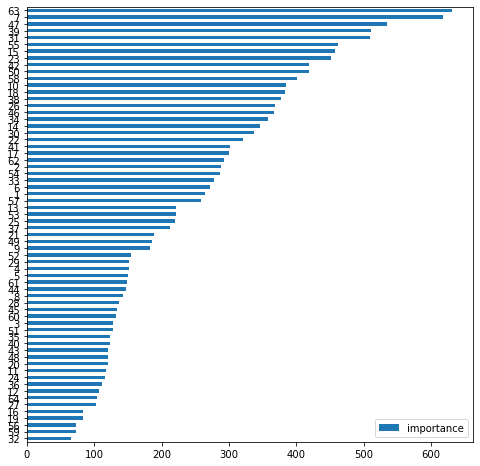

In [28]:
import matplotlib.pyplot as plt


def plot_feature_importance(model_, model_columns_):
    importance_df = pd.DataFrame(model_.feature_importance(),
                                 index=model_columns_,
                                 columns=['importance'
                                          ]).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()


plot_feature_importance(model_half_1, list(X_test.columns))

In [29]:
# import matplotlib as mpl
# submission[target].plot()
# plt.show()

In [30]:
del X_train, y_train, X_test, y_test, X_half_1, X_half_2, y_half_1, y_half_2, d_half_1, d_half_2, watchlist_1, watchlist_2, model_half_1, model_half_2
gc.collect()

10116